In [1]:
%reset
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mne
from mne import create_info
import pickle
import os
from os.path import exists

import scipy.stats as stats
from scipy.stats import sem
from scipy.signal import find_peaks
from auxiliary import AuxFuncs

In [3]:
## Import epochs
epochs_dir = 'C:\AnatArzData\YKM_data\epochs_and_evoked_allSubs'
import_type = "5Electorodes_plainEEGLAB"
trial_exclution_str = "_excOulierTrials-3.5" #"_excOulierTrials-2.5"

In [4]:
import_path = f'{epochs_dir}\\{import_type}{trial_exclution_str}.pkl'
aux = AuxFuncs(import_path)

allEpochs_perCond = aux.allEpochs_condIdDict
allEvents_df = aux.allEvents_df
c = aux.config
times = c['times']
time0_i = c['time0_i']

fig_output_dir = f"{c['outputs_dir_path']}\Prete22"
if not os.path.exists(fig_output_dir):
    os.mkdir(fig_output_dir)

In [5]:
def applyDesign(ax,title='',y_lims=[-4,4]):
    fig.patch.set_facecolor('#f5f1ecff')
    ax.set_facecolor('silver')
    ax.set_title(title,fontsize = 18, fontweight = 'bold')
    ax.legend(loc = 'upper right',prop={'size': 10})
    ax.axvline(x=0,color='gray', linestyle='--',label ="_nolegend_")
    ax.axhline(y=0, color='gray', linestyle='-',label ="_nolegend_")
    ax.set_ylabel('\u03BCV', fontsize = 16, fontweight = 'bold')
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('Time (ms)', fontsize = 16, fontweight = 'bold')
    ax.set_xlim([-100,450])
    ax.set_ylim(y_lims)
    ax.text(-0.02, y_lims[1], 'stimulus', rotation=90, va='center', fontsize = 13)

colors_wngt = plt.cm.Blues([250,230,210,190,170,150,130,110,90])
colors_N2 = plt.cm.autumn_r([150,140,130,120,110,100,80,60,30])
colors_N3 = plt.cm.Greens([250,230,210,190,170,150,130,110,90])
colors_REM = plt.cm.Reds([250,230,210,190,170,150,130,110,90])
colors_allShadesPerVg = [colors_wngt,colors_N2,colors_N3,colors_REM]
colors_onePerVg = [colors_wngt[2],colors_N2[2],colors_N3[2],colors_REM[2]]
titles_onePerVg = ['Wakefulness','N2','SWS','REM']

Not setting metadata
96 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
95 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
1684 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
272 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
272 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
4650 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
7

C:\Users\Sharon\AppData\Local\Temp\ipykernel_20320\2986316488.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 4,sharex=True, sharey=False,figsize = (20,3))


Not setting metadata
97 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
99 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
1709 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
366 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
316 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
5989 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
6

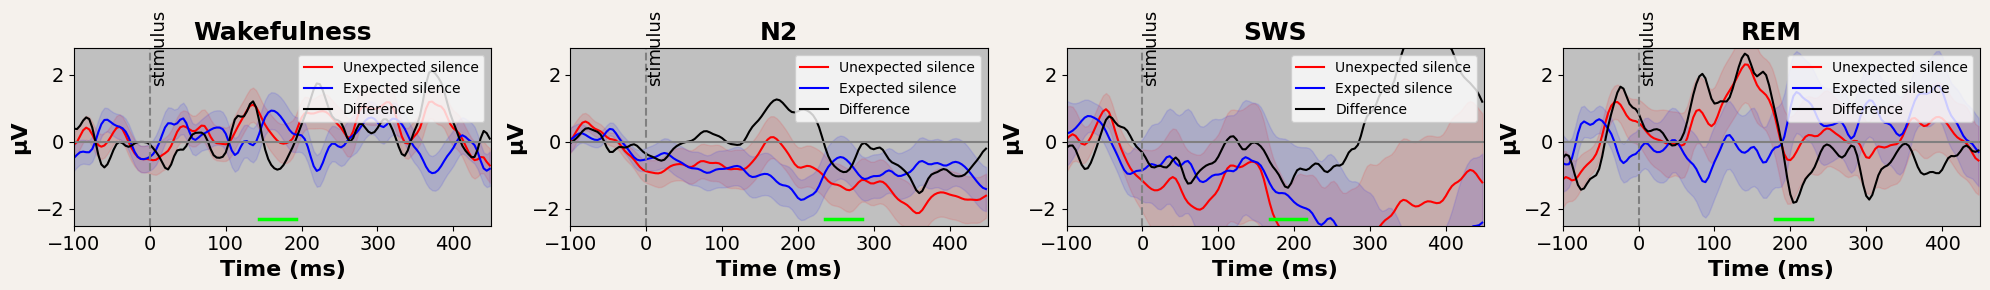

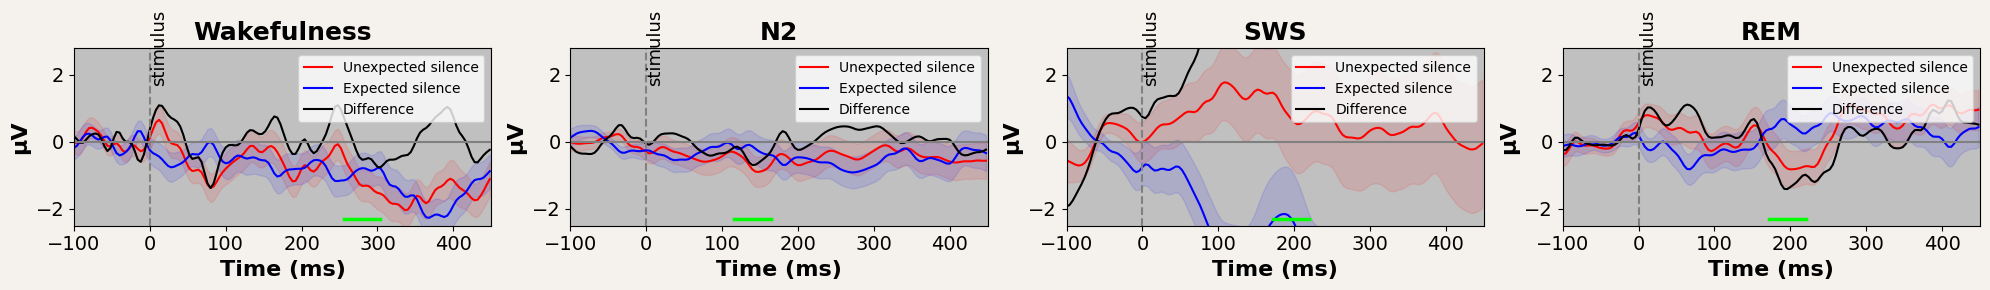

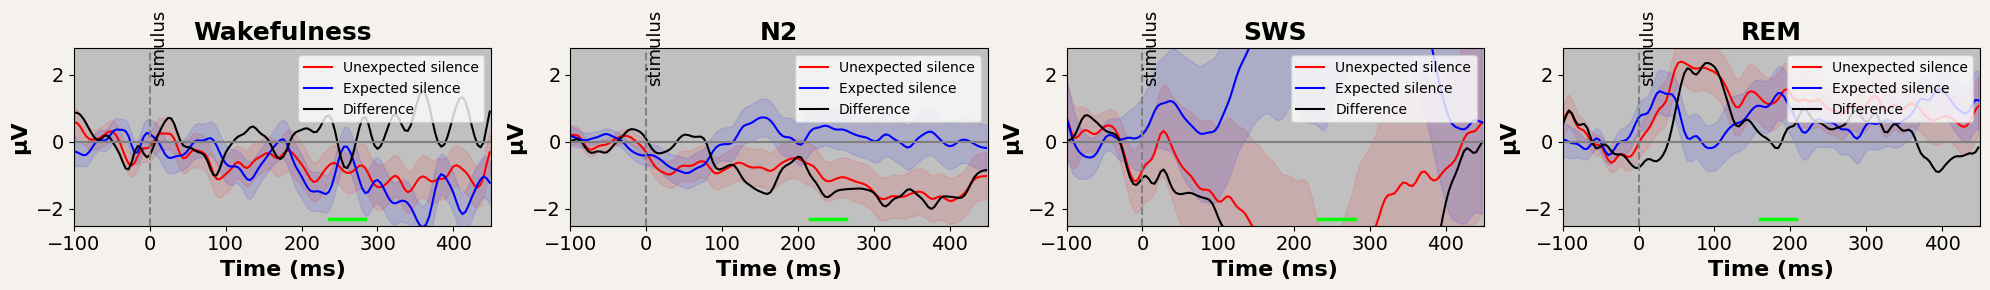

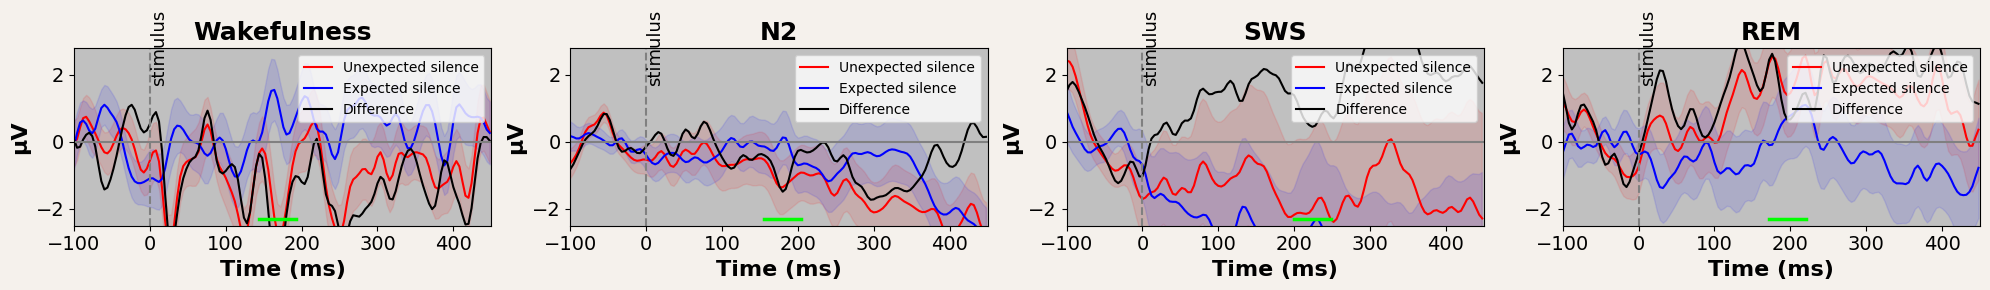

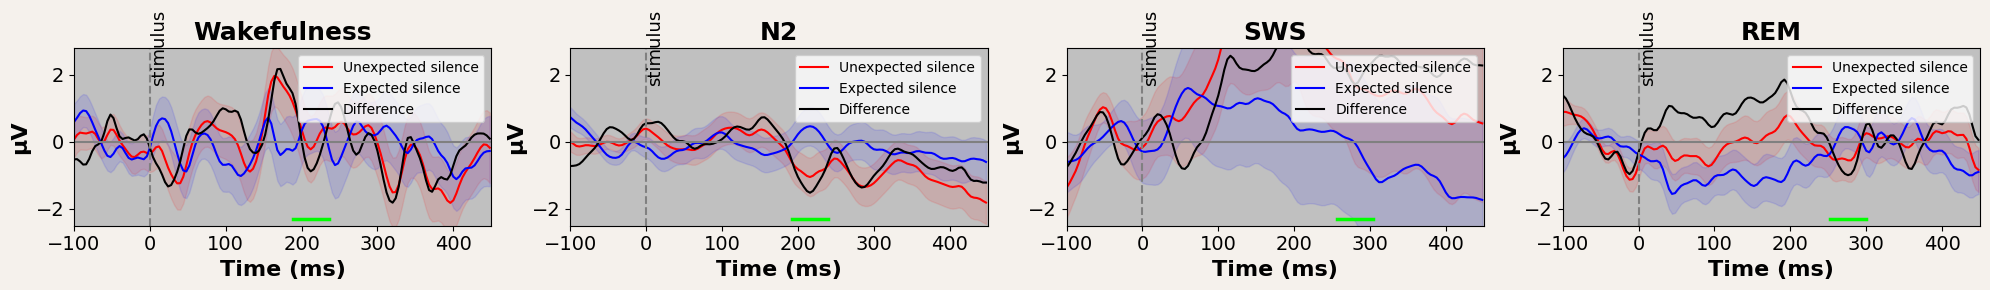

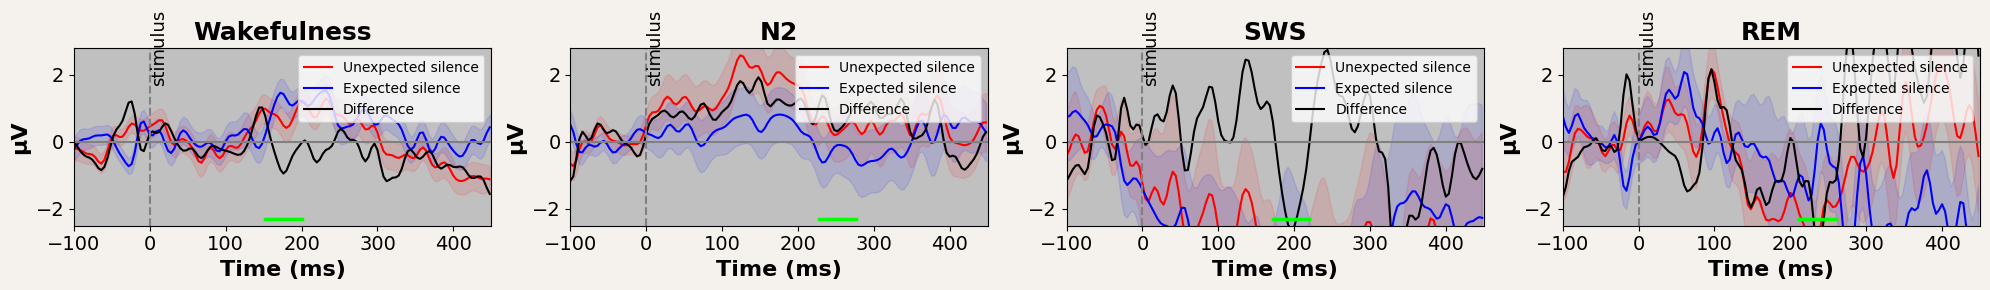

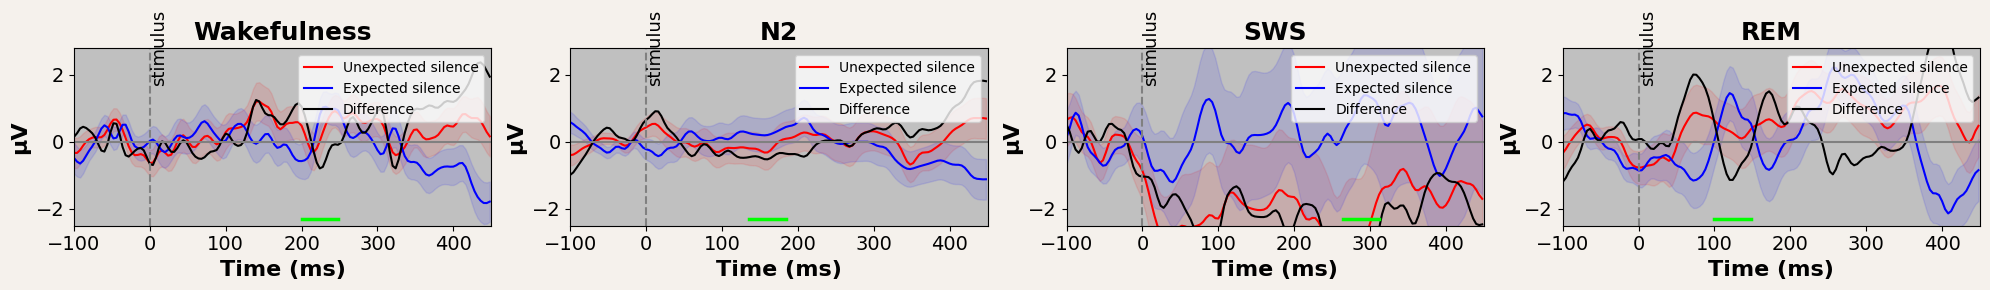

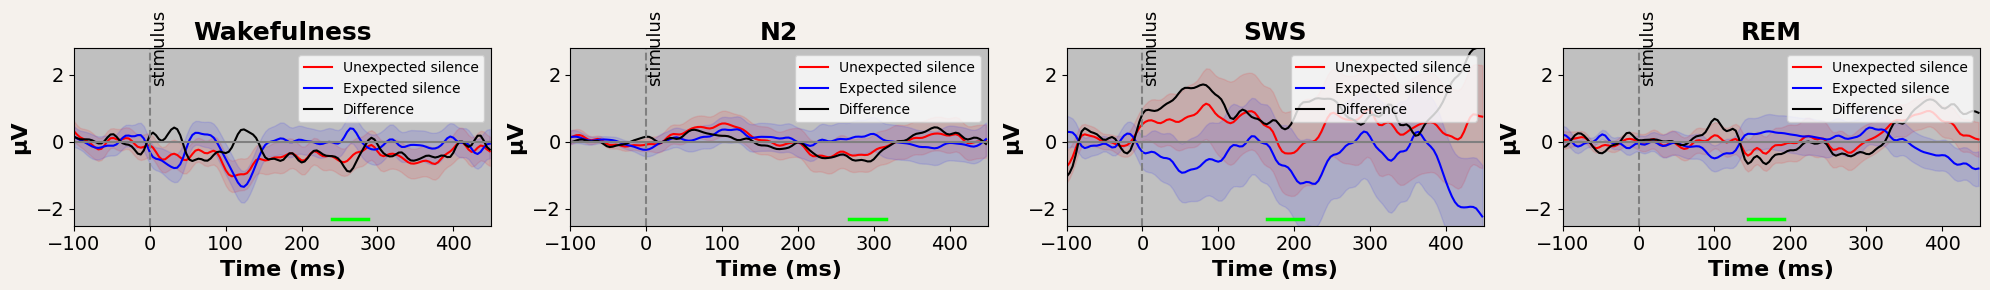

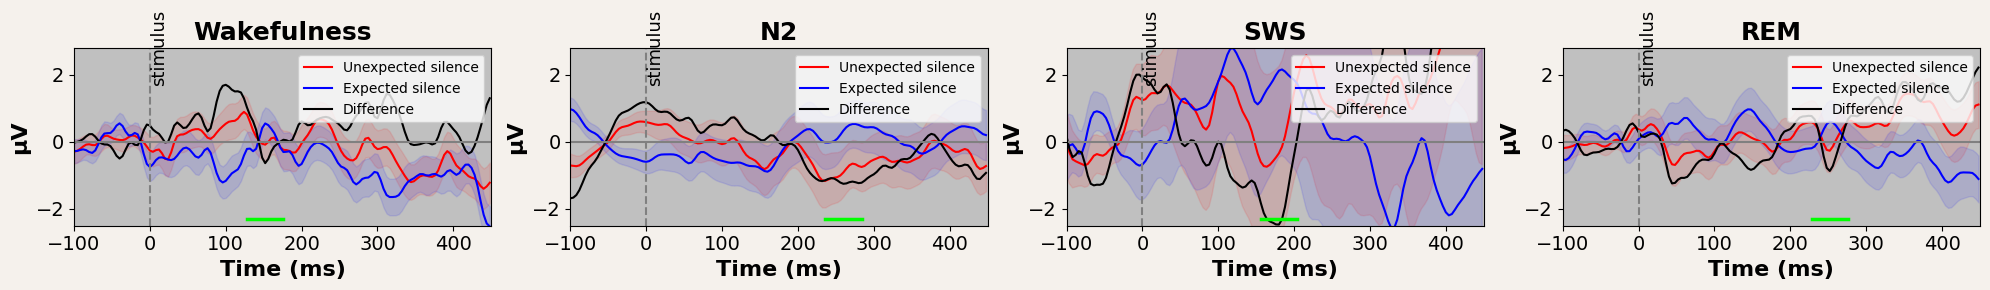

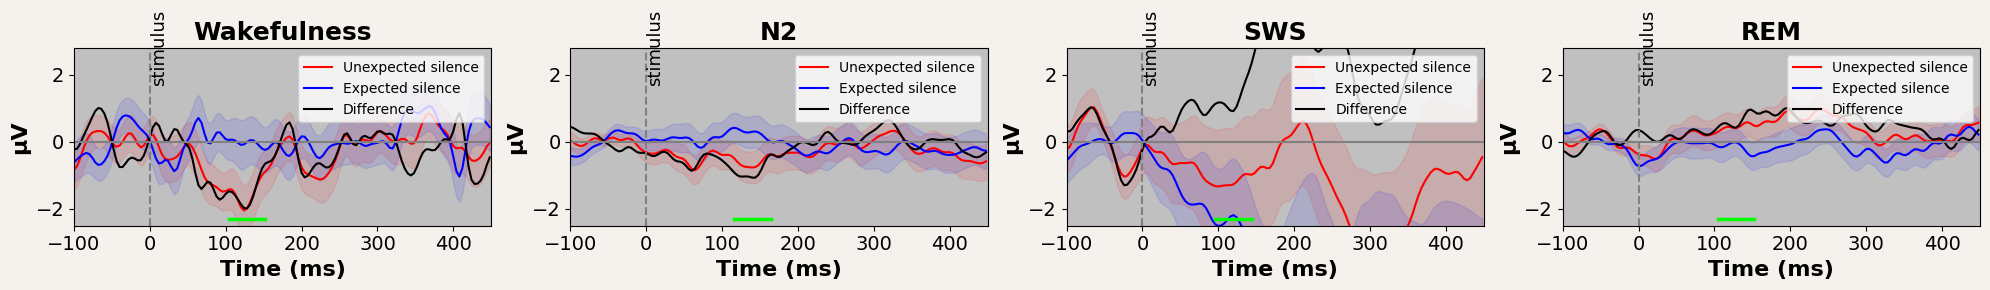

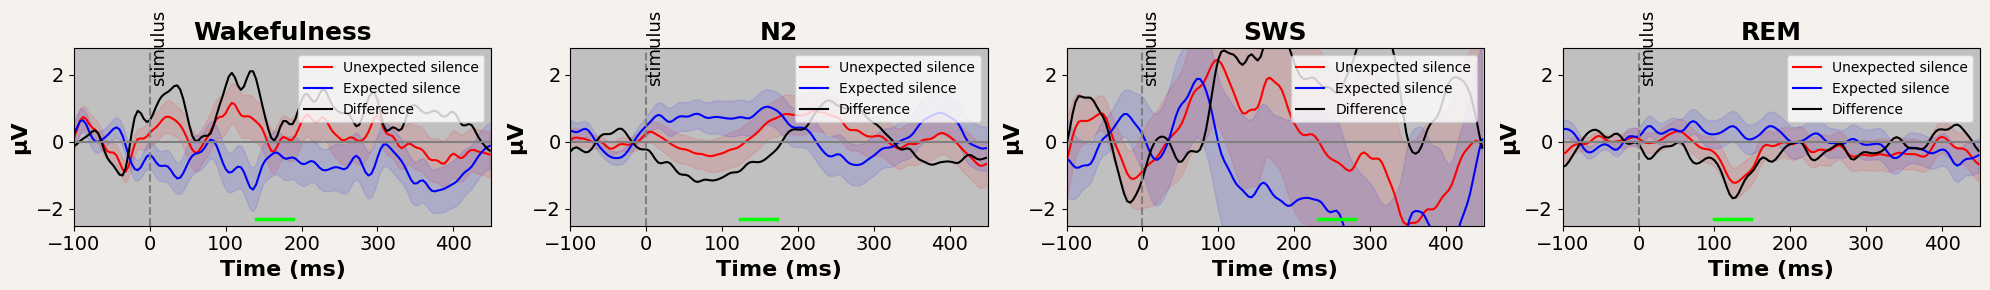

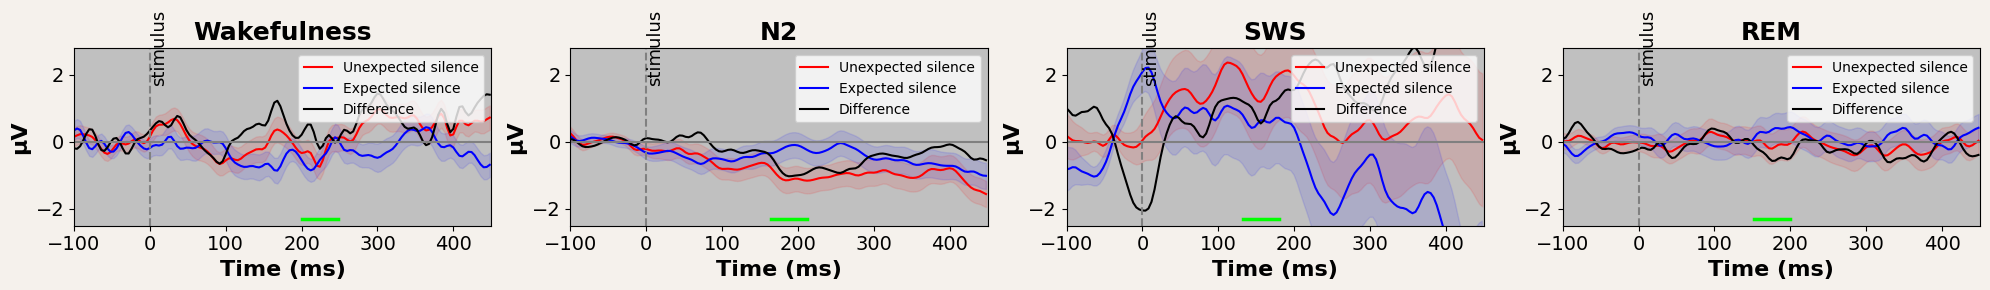

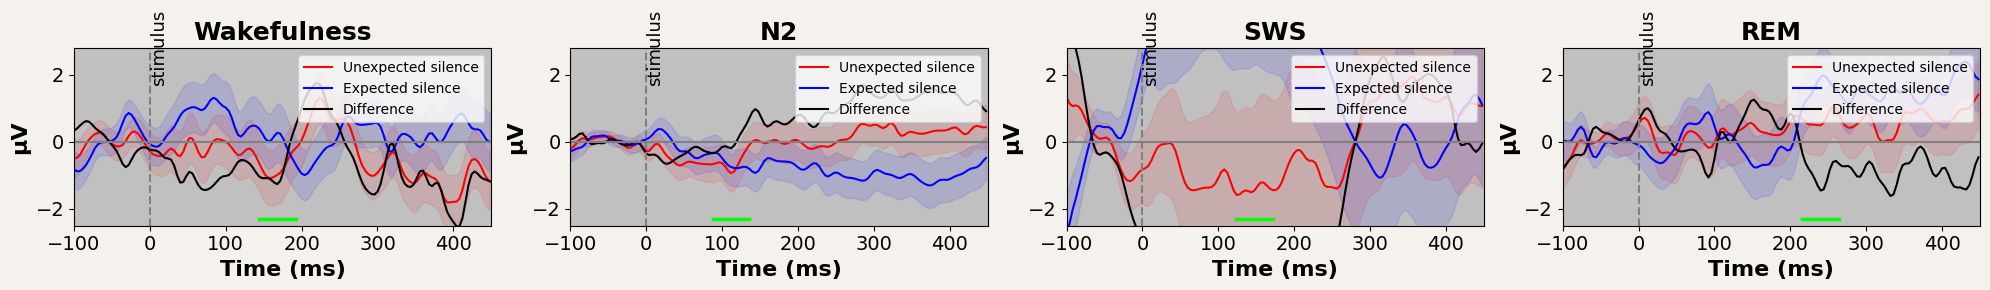

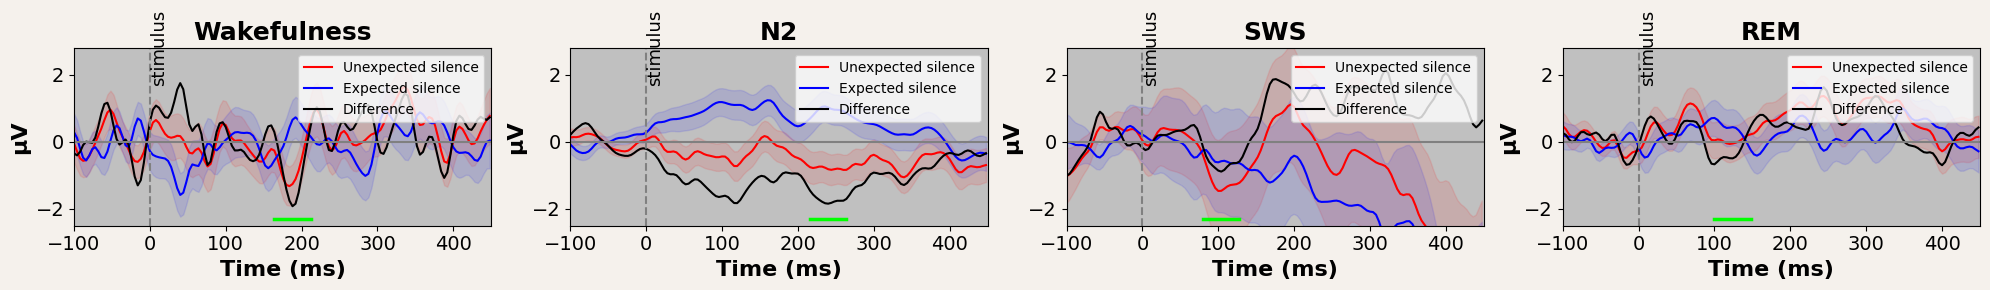

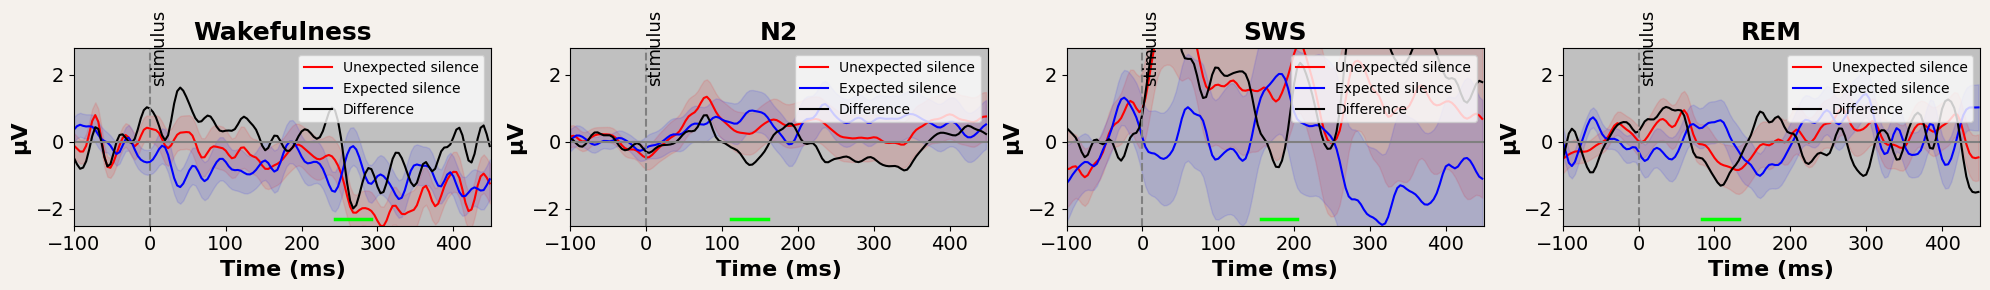

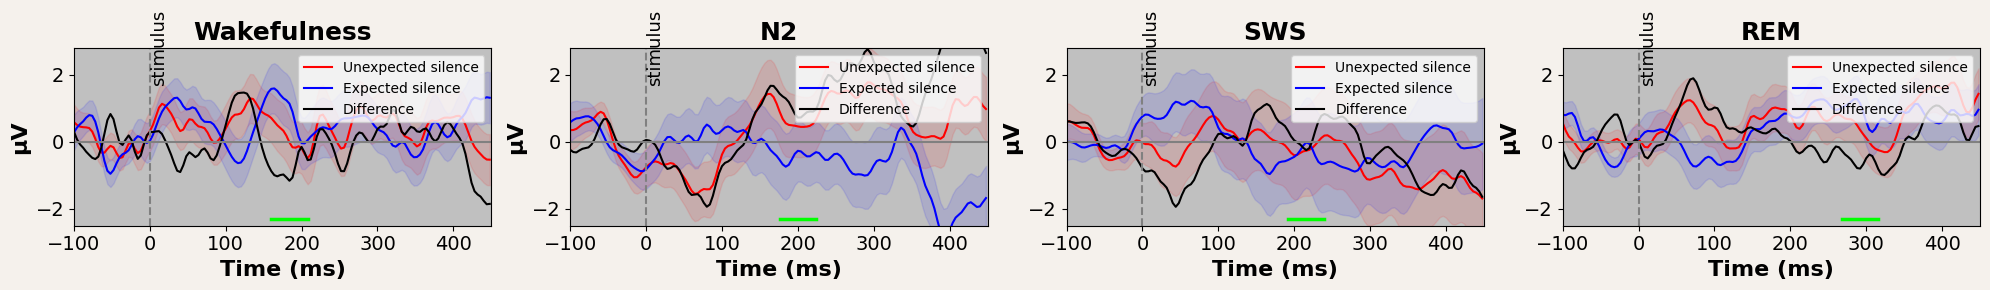

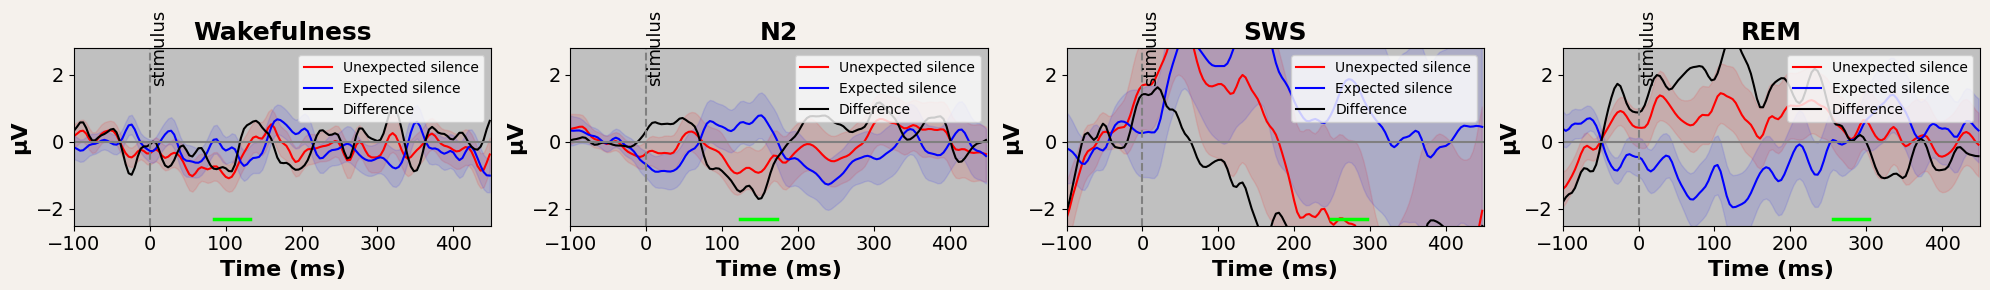

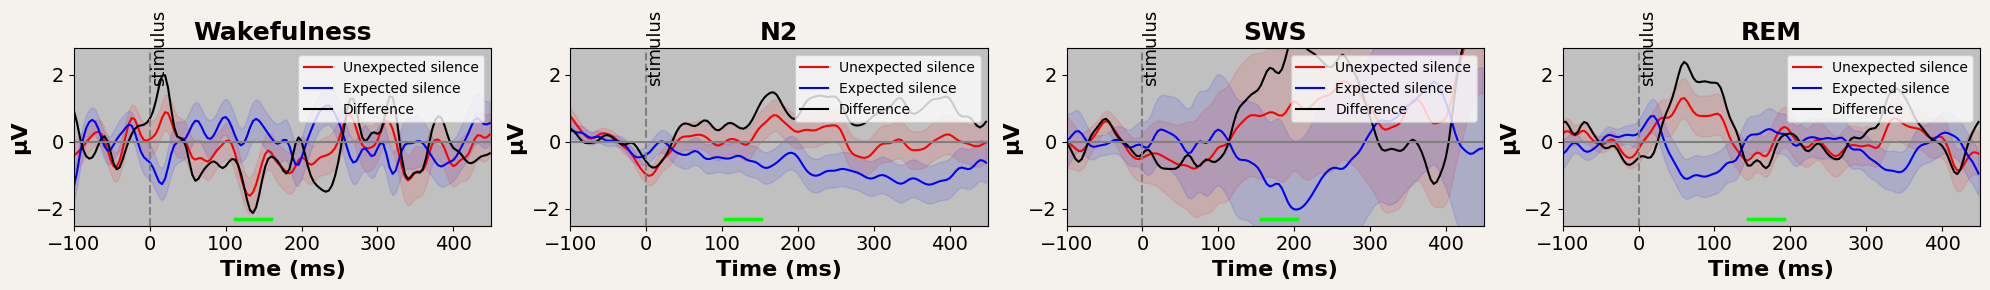

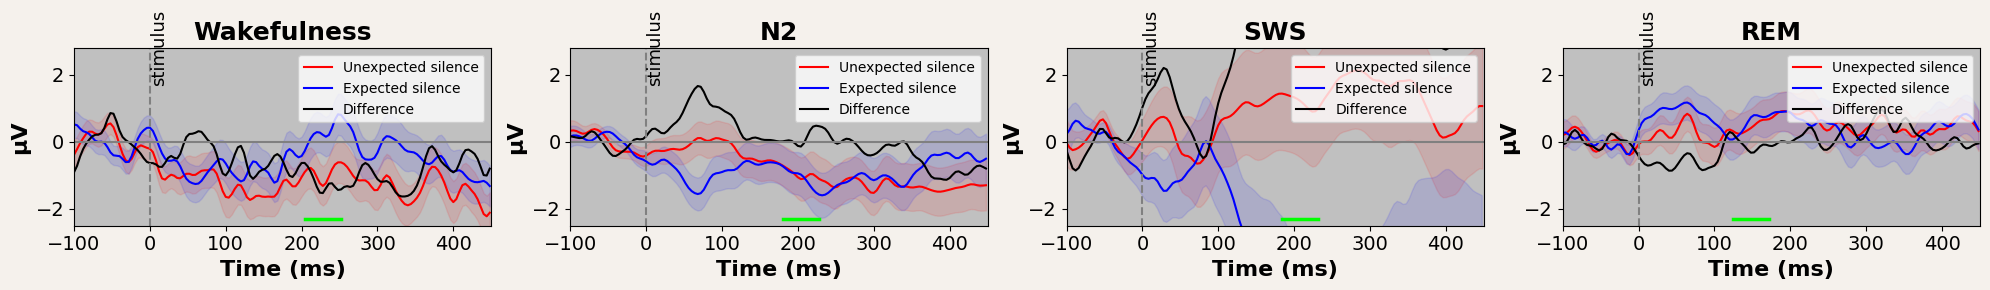

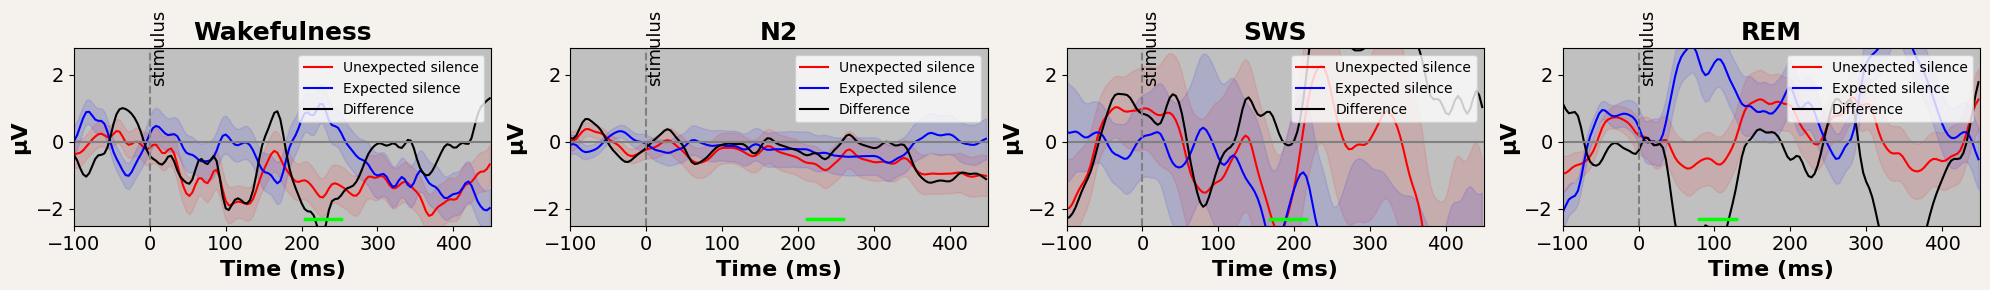

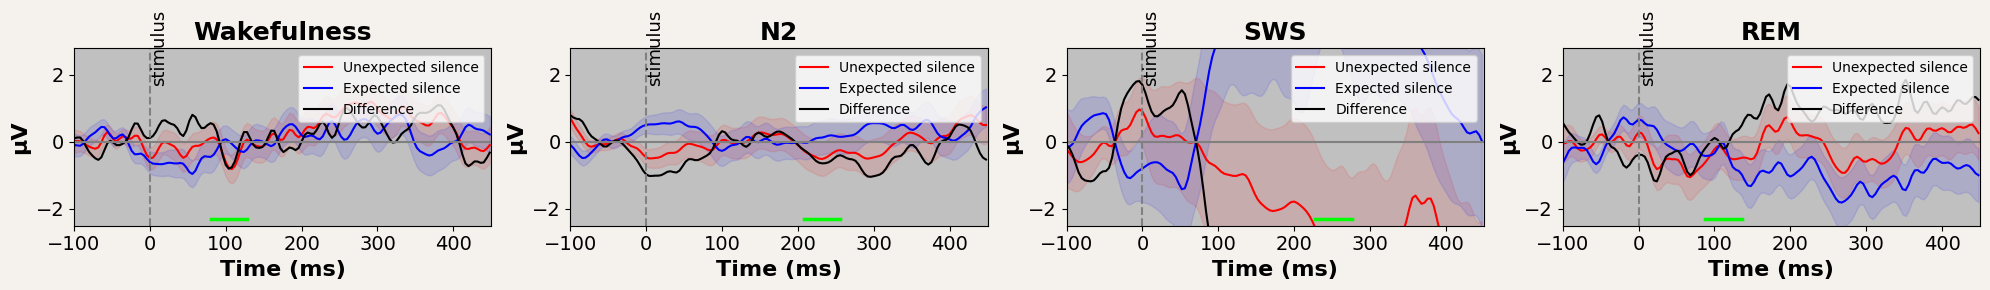

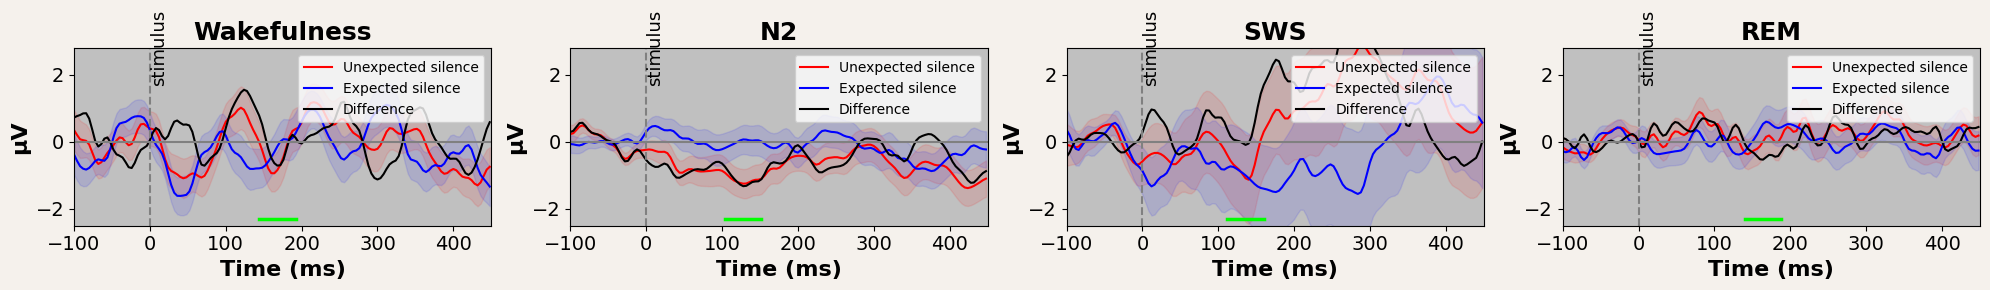

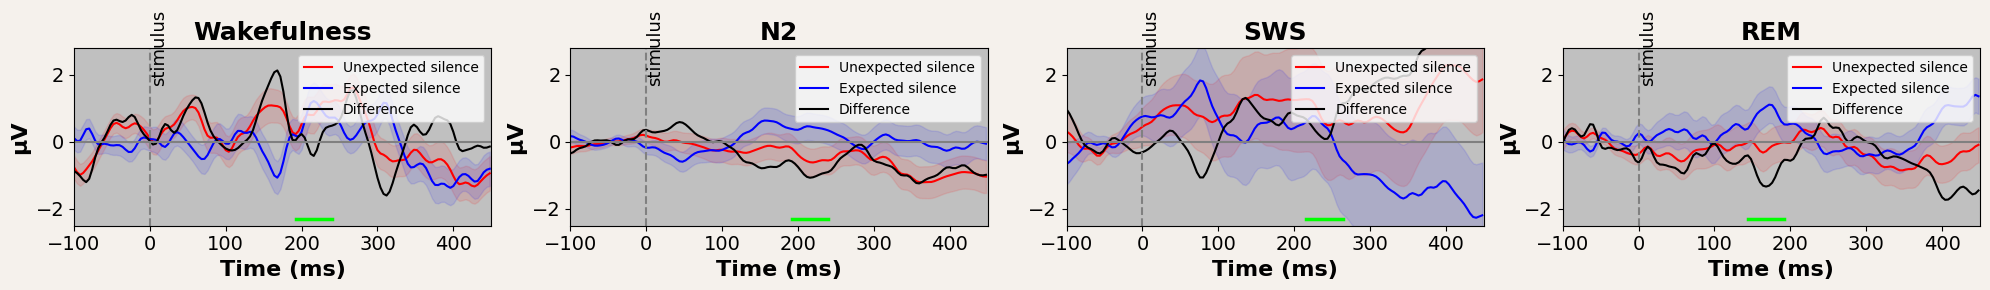

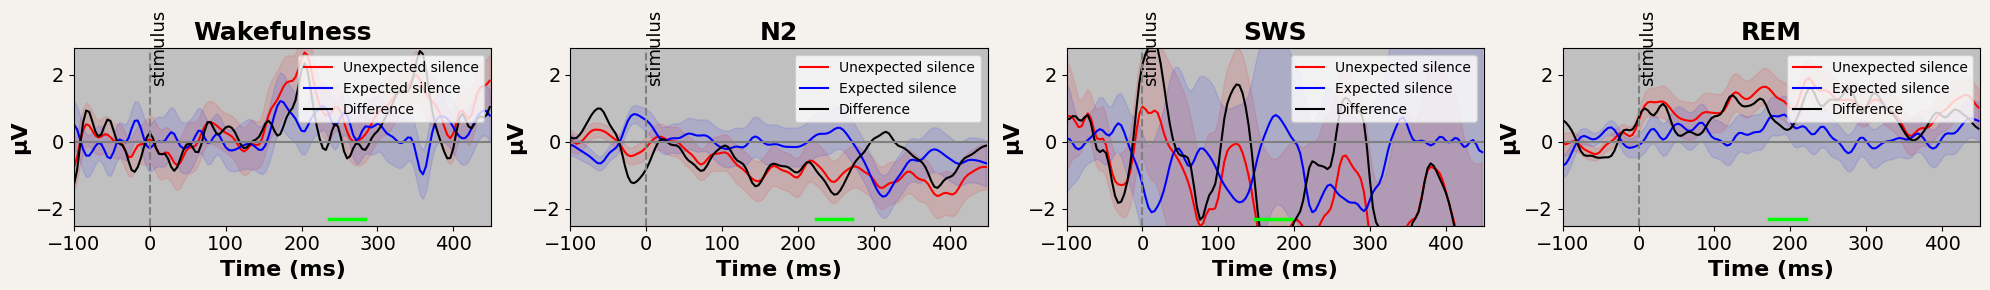

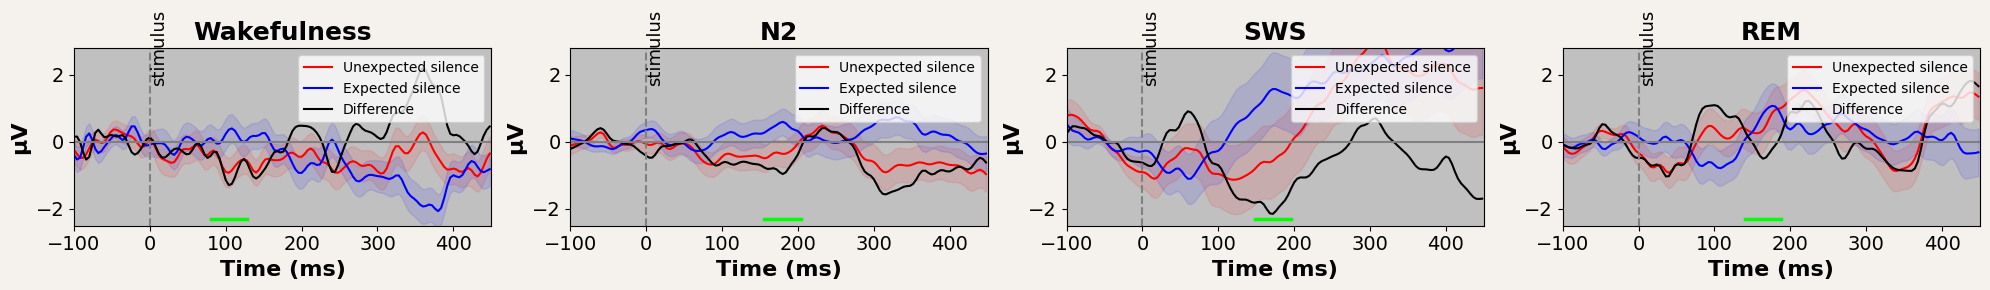

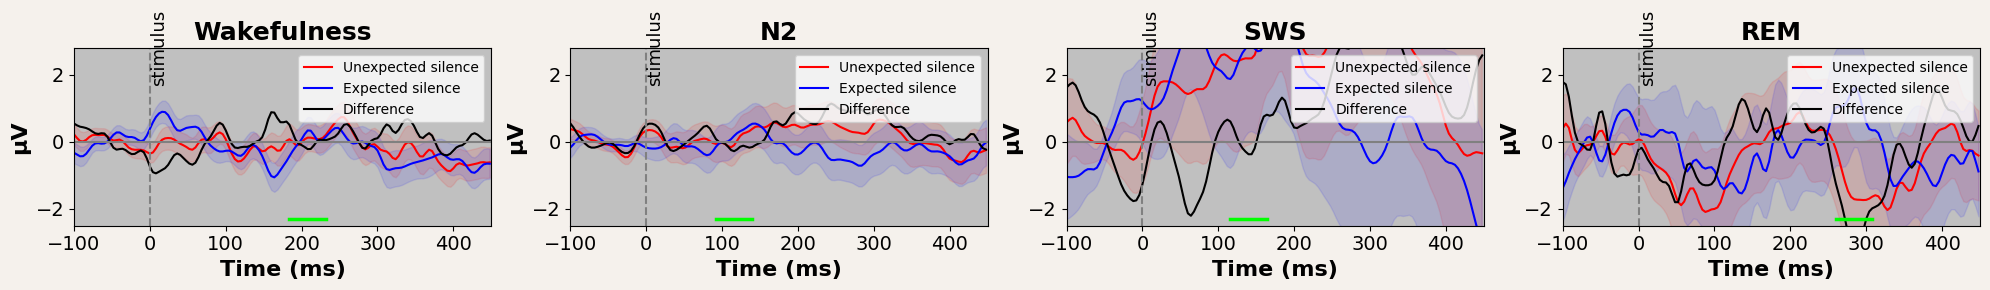

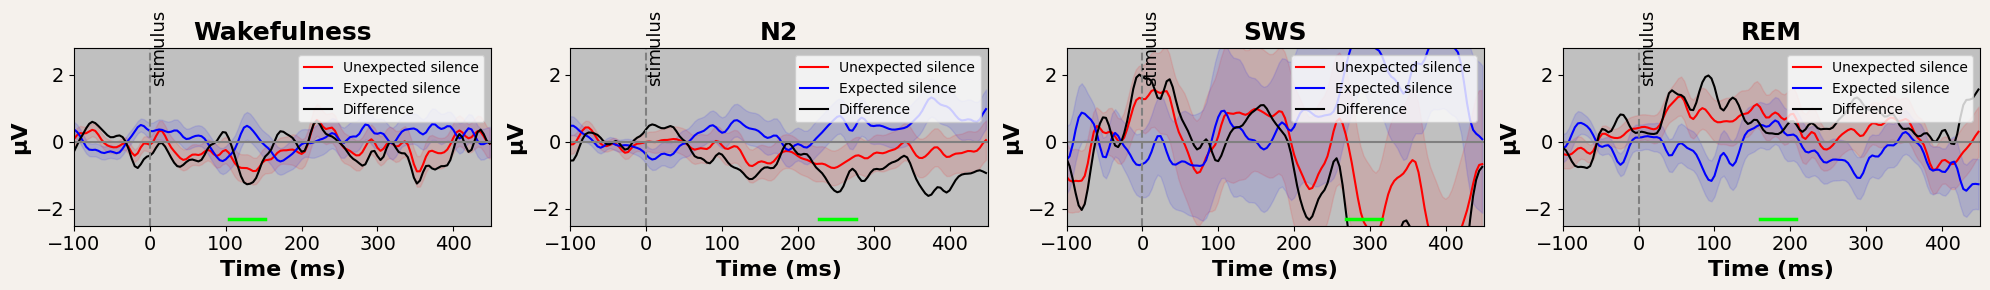

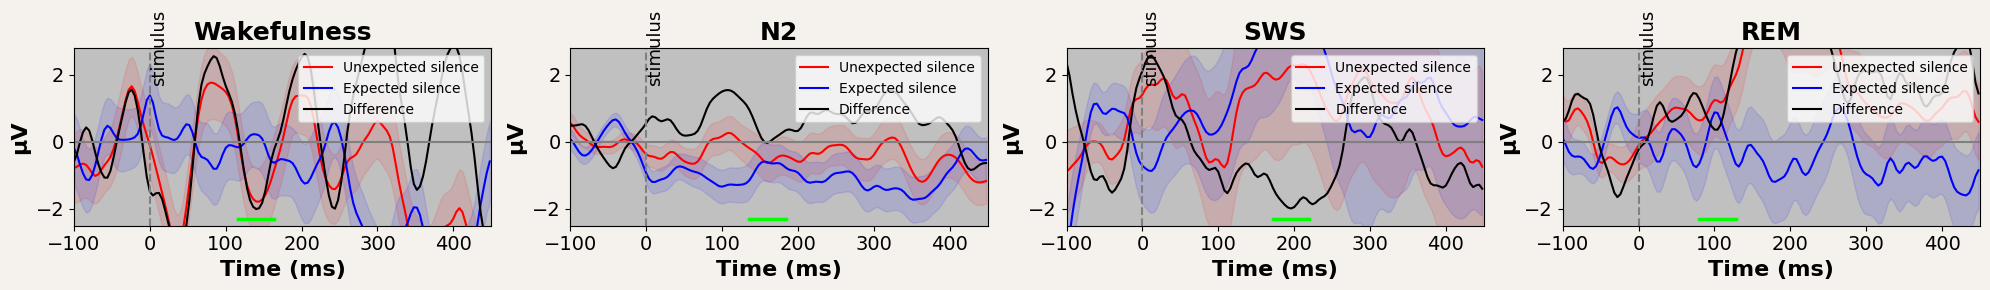

In [6]:
## Compute MMN amplitude per sub
mmn_amp_per_sub = np.zeros((len(c['subs']),len(c['vigi_states'])))
p300_amp_per_sub = np.zeros((len(c['subs']),len(c['vigi_states'])))
diff_per_SubVigi = np.zeros((len(c['subs']),len(c['vigi_states']),len(c['times'])))
mean_rand_per_SubVigi = np.zeros((len(c['subs']),len(c['vigi_states']),len(c['times'])))
mean_fixed_per_SubVigi = np.zeros((len(c['subs']),len(c['vigi_states']),len(c['times'])))

time100_i = np.where(times == 100)[0][0]
time300_i = np.where(times == 300)[0][0]

fig_output_subdir = f"{fig_output_dir}\PerSub"
if not os.path.exists(fig_output_subdir):
    os.mkdir(fig_output_subdir)


currsub_fixedAndRandrom_meanAndSte_perVG = np.zeros((5*len(c['vigi_states']), len(times)))

for subj_i, sub in enumerate(c['subs']):
    fig, axs = plt.subplots(1, 4,sharex=True, sharey=False,figsize = (20,3))
    for vigi_i, vigi in enumerate(c['vigi_states']):
        const_rand = {'Subject':sub, 'Vigilance': vigi, 'TOA_cond':'Rand'}
        const_fixed = {'Subject':sub, 'Vigilance': vigi, 'TOA_cond':'Fixed'}
        const_T = {'Subject':sub, 'Vigilance': vigi, 'TOA_cond':'T'}
        epochs_rand, __, __ = aux.getEpochsPerConstraint(const_rand)    # output: [#epochs, #elect, #times]
        epochs_fixed, __, __ = aux.getEpochsPerConstraint(const_fixed)  # output: [#epochs, #elect, #times]
        epochs_T, __, __ = aux.getEpochsPerConstraint(const_T)  # output: [#epochs, #elect, #times]
        mne_epochs_rand = mne.EpochsArray(epochs_rand, aux.info, tmin=-0.1, baseline=(None,0))
        mne_epochs_fixed = mne.EpochsArray(epochs_fixed, aux.info, tmin=-0.1, baseline=(None,0))
        mne_epochs_T = mne.EpochsArray(epochs_T, aux.info, tmin=-0.1, baseline=(None,0))
        epochs_rand = mne_epochs_rand.get_data()    # output: [#epochs, #elect, #times]
        epochs_fixed =mne_epochs_fixed.get_data()  # output: [#epochs, #elect, #times]
        epochs_T =mne_epochs_T.get_data()  # output: [#epochs, #elect, #times]

        # elecd_num = 1
        # mean_rand = np.mean(epochs_rand[:,elecd_num,:],axis = 0)
        # mean_fixed = np.mean(epochs_fixed[:,elecd_num,:],axis = 0)
        # std_rand = np.std(epochs_rand[:,elecd_num,:],axis = 0)
        # std_fixed = np.std(epochs_fixed[:,elecd_num,:],axis = 0)

        mean_rand = np.mean(epochs_rand,axis = (0,1))
        mean_fixed = np.mean(epochs_fixed,axis = (0,1))
        mean_T = np.mean(epochs_T,axis = (0,1))
        sem_rand = sem(np.mean(epochs_rand,axis = 1),axis = 0)
        sem_fixed = sem(np.mean(epochs_rand,axis = 1),axis = 0)
        diff = np.mean(np.mean(epochs_rand,axis = 0) - np.mean(epochs_fixed,axis = 0),axis = 0)

        ## save for all-subject graphs
        diff_per_SubVigi[subj_i,vigi_i,:] = diff
        mean_rand_per_SubVigi[subj_i,vigi_i,:] = mean_rand
        mean_fixed_per_SubVigi[subj_i,vigi_i,:] = mean_fixed

        
        #### Compute as in Prete22
        ## in the difference array: find local minima between 100 and 300 ms
        ## average amplitude in 50ms window around the peak (25 each side)
        diff_mmn_time = diff[time100_i:time300_i]
        peaks, _ = find_peaks(-diff_mmn_time)
        min_in_mmn_range = np.min(diff_mmn_time[peaks])
        min_i_in_mmn_range = np.where(diff_mmn_time == min_in_mmn_range)[0][0]

        range_for_mean_min = time100_i + min_i_in_mmn_range - 6 # -26ms
        range_for_mean_max = time100_i + min_i_in_mmn_range + 6 # +26ms

        mean_around_min = np.mean(diff[range_for_mean_min:range_for_mean_max])
        mmn_amp_per_sub[subj_i,vigi_i] = mean_around_min


        ## plot per subject and vigi
        # axs[vigi_i].plot(times,np.mean(epochs_rand,axis = 1).T,color='red',alpha=0.08, linewidth=0.5)
        # axs[vigi_i].plot(times,np.mean(epochs_fixed,axis = 1).T,color='blue',alpha=0.08, linewidth=0.5)
        #axs[vigi_i].plot(times,np.mean(epochs_T,axis = 1).T,color='green',alpha=0.08, linewidth=0.5)
        axs[vigi_i].fill_between(times,mean_rand+sem_rand,mean_rand-sem_rand, color='red',alpha=0.1,label ="_nolegend_")
        label = f"Unexpected silence"#, n={epochs_rand.shape[0]}"
        axs[vigi_i].plot(times,mean_rand,color='red',label=label)
        #axs[vigi_i].plot(times,mean_T,color='green',label="Standard Tone")
        axs[vigi_i].fill_between(times,mean_fixed+sem_fixed,mean_fixed-sem_fixed, color='blue',alpha=0.1,label ="_nolegend_")
        label = f"Expected silence"#, n={epochs_fixed.shape[0]}"
        axs[vigi_i].plot(times,mean_fixed,color='blue',label=label)
        axs[vigi_i].plot(times,diff,color='black',label='Difference')
        plot_title = f'{titles_onePerVg[vigi_i]}'#, sub {sub}'
        applyDesign(axs[vigi_i],plot_title,y_lims=[-2.5,2.8])
        ## add line around the mean
        axs[vigi_i].plot([times[range_for_mean_min],times[range_for_mean_max]], [-2.3,-2.3], color = 'lime', linewidth = 2.5,label =f"{range_for_mean_min},{range_for_mean_max}")
     

        #### find p300 same way
        ## in the difference array: find local maxima between 300 and 450 ms
        ## average amplitude in 50ms window around the peak (25 each side)
        diff_p300_time = diff[time300_i:-1]
        peaks, _ = find_peaks(-diff_p300_time)
        max_in_p300_range = np.max(diff_p300_time[peaks])
        max_i_in_p300_range = np.where(diff_p300_time == max_in_p300_range)[0][0]

        range_for_mean_min = time300_i + max_i_in_p300_range - 6 # -26ms
        range_for_mean_max = time300_i + max_i_in_p300_range + 6 # +26ms

        mean_around_max = np.mean(diff[range_for_mean_min:range_for_mean_max])
        p300_amp_per_sub[subj_i,vigi_i] = mean_around_max


        ## saves graphs in csv for Anat
        # currsub_fixedAndRandrom_meanAndSte_perVG[vigi_i*5 + 0, :] = diff
        # currsub_fixedAndRandrom_meanAndSte_perVG[vigi_i*5 + 1, :] = mean_rand
        # currsub_fixedAndRandrom_meanAndSte_perVG[vigi_i*5 + 2, :] = sem_rand
        # currsub_fixedAndRandrom_meanAndSte_perVG[vigi_i*5 + 3, :] = mean_fixed
        # currsub_fixedAndRandrom_meanAndSte_perVG[vigi_i*5 + 4, :] = sem_fixed


        # def get_contrasts_ax(ax, contrasts, contrastsColors,cluster_res):
        #     for s,contrast in enumerate(contrasts):
        #         contrast_str = f"{contrast[0]}_{contrast[1]}"
        #         curr_cl = cluster_res[contrast_str]['cl_']
        #         for i in range(len(curr_cl)):
        #             ax.plot([curr_cl[i][0],curr_cl[i][1]], [-2,-2],'-', color = 'black', linewidth = 2.5)
                    
    
    # np.savetxt(f'{fig_output_dir}/sub{sub}_fixedAndRandom_meanAndSte_perVG.csv', currsub_fixedAndRandrom_meanAndSte_perVG, delimiter=",")
    plt.tight_layout()
    plt.ioff()
    plt.savefig(f'{fig_output_subdir}/sub{sub}_5CentElectMean.png')
    #plt.show()

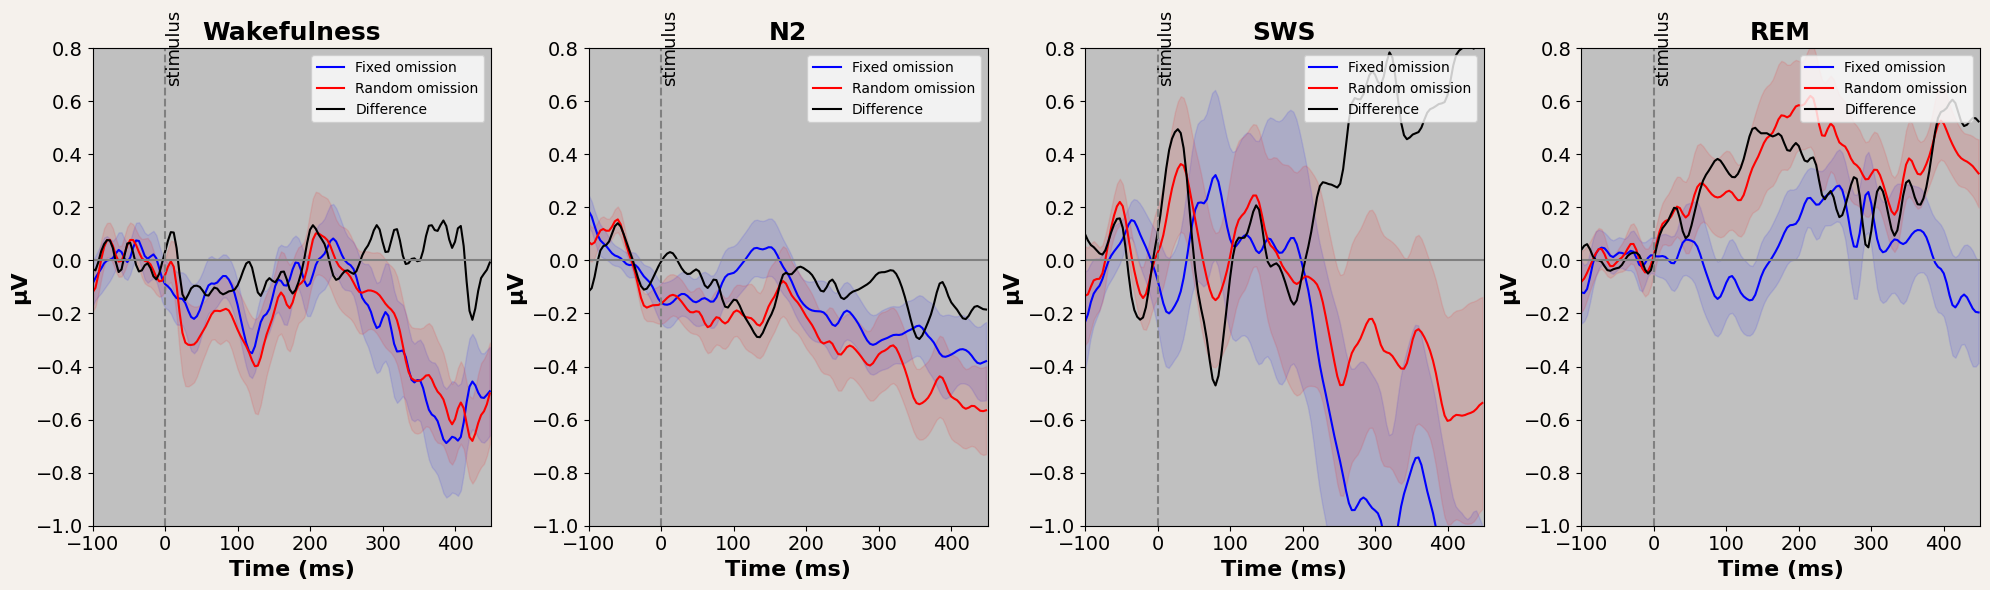

In [7]:
fig, axs = plt.subplots(1, 4,sharex=True, sharey=False,figsize = (20,6))

allSubs_fixedAndRandrom_meanAndSte_perVG = np.zeros((5*len(c['vigi_states']), len(times)))
for vigi_i, vigi in enumerate(c['vigi_states']):
    diff = np.mean(diff_per_SubVigi[:,vigi_i,:],axis=0)
    mean_rand = np.mean(mean_rand_per_SubVigi[:,vigi_i,:],axis=0)
    sem_rand = sem(mean_rand_per_SubVigi[:,vigi_i,:],axis=0)
    mean_fixed = np.mean(mean_fixed_per_SubVigi[:,vigi_i,:],axis=0)
    sem_fixed = sem(mean_fixed_per_SubVigi[:,vigi_i,:],axis=0)

    ## saves graphs in csv for Anat
    allSubs_fixedAndRandrom_meanAndSte_perVG[vigi_i*5 + 0, :] = diff
    allSubs_fixedAndRandrom_meanAndSte_perVG[vigi_i*5 + 1, :] = mean_rand
    allSubs_fixedAndRandrom_meanAndSte_perVG[vigi_i*5 + 2, :] = sem_rand
    allSubs_fixedAndRandrom_meanAndSte_perVG[vigi_i*5 + 3, :] = mean_fixed
    allSubs_fixedAndRandrom_meanAndSte_perVG[vigi_i*5 + 4, :] = sem_fixed

    axs[vigi_i].fill_between(times,mean_fixed+sem_fixed,mean_fixed-sem_fixed, color='blue',alpha=0.1,label ="_nolegend_")
    label = f"Fixed omission"#, n={len(c['subs'])}"
    axs[vigi_i].plot(times,mean_fixed,color='blue',label=label)
    axs[vigi_i].fill_between(times,mean_rand+sem_rand,mean_rand-sem_rand, color='red',alpha=0.1,label ="_nolegend_")
    label = f"Random omission"#, n={len(c['subs'])}"
    axs[vigi_i].plot(times,mean_rand,color='red',label=label)
    axs[vigi_i].plot(times,diff,color='black',label='Difference')
    plot_title = f'{titles_onePerVg[vigi_i]}'
    applyDesign(axs[vigi_i],plot_title,y_lims=[-1,0.8])
plt.tight_layout()
#plt.ioff()
plt.savefig(f'{fig_output_dir}/allSubs_5CentElectMean.png')
plt.show()


## saves graphs in csv for Anat
np.savetxt(f'{fig_output_dir}/allSubs_fixedAndRandom_meanAndSte_perVG.csv', allSubs_fixedAndRandrom_meanAndSte_perVG, delimiter=",")


In [8]:
### compute t-tests: MNN
for vigi_i, vigi in enumerate(c['vigi_states']):
    t_statistic, p_value = stats.ttest_1samp(a=mmn_amp_per_sub[:,vigi_i], popmean=0,alternative='less')
    print(f'Vigilance: {vigi}, t_statistic = {t_statistic}, p_value = {float("{:.8f}".format(float(p_value)))}')

Vigilance: Wn, t_statistic = -4.387641022625983, p_value = 7.884e-05
Vigilance: N2, t_statistic = -4.443429653422536, p_value = 6.79e-05
Vigilance: N3, t_statistic = -1.5735155102313638, p_value = 0.06362293
Vigilance: REM, t_statistic = -2.581045956311893, p_value = 0.00780172


In [9]:
### compute t-tests: P300
for vigi_i, vigi in enumerate(c['vigi_states']):
    t_statistic, p_value = stats.ttest_1samp(a=p300_amp_per_sub[:,vigi_i], popmean=0,alternative='greater')
    print(f'Vigilance: {vigi}, t_statistic = {t_statistic}, p_value = {float("{:.8f}".format(float(p_value)))}')

Vigilance: Wn, t_statistic = 1.0421068952228854, p_value = 0.15330193
Vigilance: N2, t_statistic = 0.11582455215194955, p_value = 0.45432438
Vigilance: N3, t_statistic = 1.360773085356743, p_value = 0.09241846
Vigilance: REM, t_statistic = 3.790317962607279, p_value = 0.00038434


In [10]:
np.savetxt(f'{fig_output_dir}/AverageAroundMin_subXvigilance.csv', mmn_amp_per_sub, delimiter=",")
mmn_amp_per_sub

array([[-0.39766951, -0.6279829 , -0.97842511, -0.86116898],
       [-0.22279001, -0.44447846,  3.37523214, -1.08894447],
       [-0.01237425, -1.40571447, -9.44278004,  0.1379781 ],
       [-2.19303199, -0.8408474 ,  0.8015026 ,  1.43267327],
       [-0.04434799, -1.14752271,  2.05512222, -0.55375133],
       [-0.31337989,  0.77563319, -1.48540534, -1.81766554],
       [-0.08448313, -0.43224162, -3.81502243, -0.56088444],
       [-0.54745101, -0.48691812,  0.61669777, -0.50631329],
       [ 0.05682402, -1.17362304, -1.90397558, -0.07430119],
       [-1.55895756, -0.91875531,  1.27748437,  0.60535777],
       [ 0.6852189 , -0.58487649,  1.735508  , -1.19663058],
       [ 0.16595287, -0.86419842,  0.96626749, -0.40145566],
       [-0.85606124, -0.03820125, -6.15860973, -0.92689347],
       [-0.93312837, -1.72624693, -0.6563891 , -0.35099893],
       [-0.85414504, -0.43340987,  0.04108232, -0.92868892],
       [-0.79859822,  1.01022888,  0.13610456, -0.53216753],
       [-0.46918652, -1.

In [11]:
p300_amp_per_sub

array([[ 1.78274776e-01, -8.94564113e-01,  1.64721229e+00,
        -4.82682434e-01],
       [-5.52006423e-01,  9.16567727e-02,  5.70387663e+00,
         8.72138675e-01],
       [ 7.90421803e-01, -1.54564136e+00, -3.76091001e-01,
         3.19662710e-01],
       [-1.14657206e+00, -3.34752881e-01,  3.73723363e+00,
         2.55708180e+00],
       [-9.31321550e-01, -6.81313944e-01,  2.46871726e+00,
         8.32085065e-01],
       [-4.20758645e-01,  9.29341683e-01, -6.45837027e-01,
         3.30527371e+00],
       [ 1.27332213e+00,  4.11536271e-01, -2.11632511e+00,
         1.68490816e+00],
       [-6.06708834e-02,  2.90025998e-01,  8.19981786e-01,
         1.11094033e+00],
       [ 1.10247063e-01, -4.71270107e-01,  2.22504995e+00,
         1.56680331e+00],
       [ 1.04398460e-01,  3.91016048e-02,  3.15444853e+00,
         5.32614488e-01],
       [ 9.34793141e-01, -8.73381856e-02,  3.77096744e-01,
         3.23573297e-01],
       [ 9.11303446e-01, -4.13024109e-01,  2.74076012e+00,
      